In [75]:
import zombie_imp
import csv
import serial
import time 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import pywt
import numpy as np
from scipy import stats
import statistics
from scipy.interpolate import interp1d
from sklearn.neighbors import KNeighborsClassifier

In [100]:
class RingBuffer:
    def __init__(self, size):
        self.size = size
        self.data = [None] * size
        self.head = 0
        self.tail = 0
        self.count = 0

    def append(self, item):
        if self.count < self.size:
            self.data[self.tail] = item
            self.tail = (self.tail + 1) % self.size
            self.count += 1
        else:
            # If the buffer is full, overwrite the oldest data
            self.data[self.head] = item
            self.head = (self.head + 1) % self.size
            self.tail = (self.tail + 1) % self.size

    def get(self):
        return [self.data[(self.head + i) % self.size] for i in range(self.count)]
    
    def clear(self):
        self.data = [None] * self.size
        self.head = 0
        self.tail = 0
        self.count = 0

    def __len__(self):
        return self.count


In [76]:
# Initialize the Serial port
ser = serial.Serial('COM3', 115200)  # Change the port and baud rate according to transmitter

# create the CSV file
# with open('sensor_data.csv', mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['Cell 1', 'Cell 2', 'Cell 3'])  

#     # read the data from port and store in CSV file
#     try:
#         while True:
#             data = ser.readline().decode('utf-8', errors='ignore').strip()  # read data from port
#             if data:
#                 values = data.split(' ')  # split with space
#                 if len(values) == 3:  # make sure there are three values
#                     writer.writerow([int(val) for val in values])  # store the data
#     except KeyboardInterrupt:  # stop iteration by Ctrl+C
#         pass

# for one cell
with open('sensor_data.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Sensor Value'])  # 写入表头

    # 循环读取串口数据并写入 CSV 文件
    try:
        while True:
            data = ser.readline().decode('utf-8').strip()  # 从串口读取数据
            if data:
                writer.writerow([int(data)])  # 将传感器值写入CSV文件，不包括时间戳
    except KeyboardInterrupt:  # 当用户按下Ctrl+C时停止循环
        # ser.close()
        pass
    finally:
        # 关闭串口
        ser.close()

AttributeError: module 'serial' has no attribute 'Serial'

In [77]:
# read the csv file
df_1 = pd.read_csv('flat_hand.csv')
df_2 = pd.read_csv('vertical_hand.csv')

# get the data of each solar cell
solar_cell_1 = df_1['Sensor Value']
solar_cell_2 = df_2['Sensor Value']
# solar_cell_2 = df['Cell 2']
# solar_cell_3 = df['Cell 3']

# apply DWT for the current value of each solar cell
coeffs_1 = pywt.wavedec(solar_cell_1, 'haar', level=5) #coeffs_1[0] contains the first-level approximation coefficient of solar_cell_1, coeffs_1[1] contains the first-level detail coefficient of solar_cell_1
coeffs_2 = pywt.wavedec(solar_cell_2, 'haar', level=5)
# coeffs_2 = pywt.wavedec(solar_cell_2, 'haar', level=5)
# coeffs_3 = pywt.wavedec(solar_cell_3, 'haar', level=5)

# cA5, cD5, cD4, cD3, cD2, cD1 = coeffs_1

# print("Coefficients for solar_cell_1:", cA5)
# print("Coefficients for solar_cell_2:", coeffs_2)
# print("Coefficients for solar_cell_3:", coeffs_3)

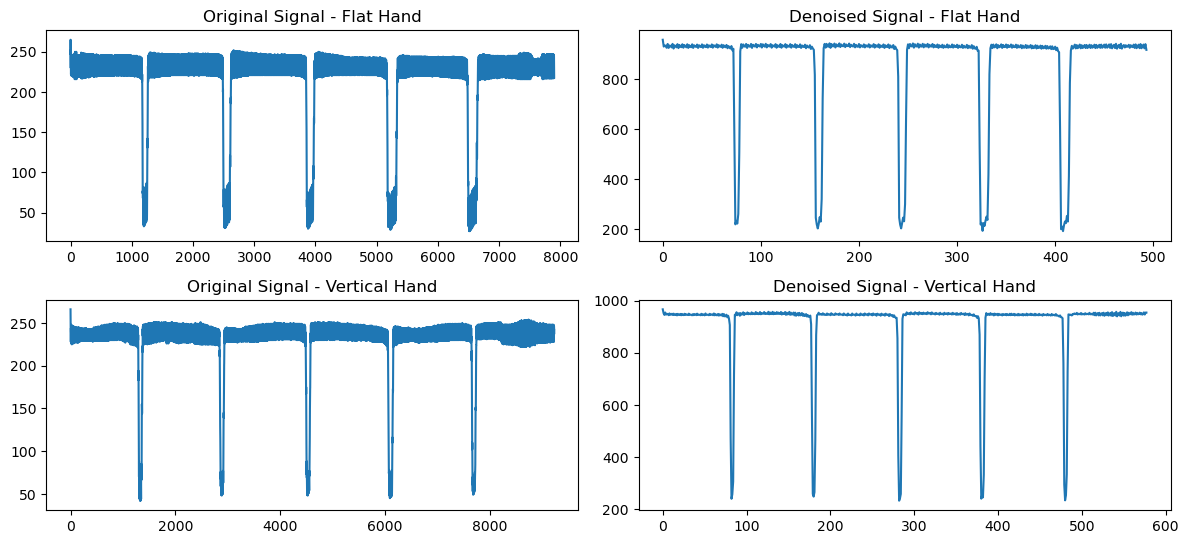

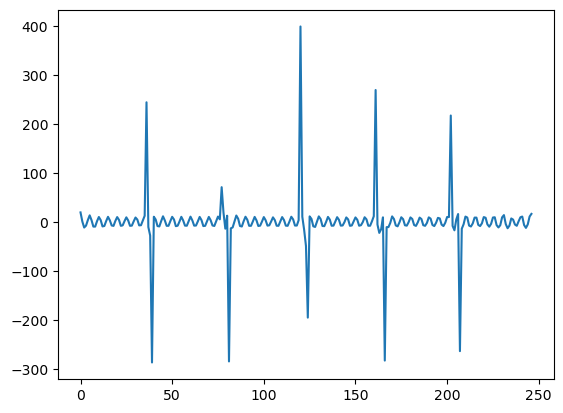

In [133]:
# approx_coeff_1 = stats.zscore(coeffs_1[0])
# detail_coeff_1 = stats.zscore(coeffs_1[1])
approx_coeff_1 = coeffs_1[0]
detail_coeff_1 = coeffs_1[1]
approx_coeff_2 = coeffs_2[0]
detail_coeff_2 = coeffs_2[1]
# approx_coeff_3 = coeffs_3[0]
# detail_coeff_3 = coeffs_3[1]

# should be changed based on reality
threshold = 0.4

# apply a threshold on detail coeffcient
detail_coeff_thresh_1 = pywt.threshold(detail_coeff_1, threshold, mode='soft')
detail_coeff_thresh_2 = pywt.threshold(detail_coeff_2, threshold, mode='soft')
# detail_coeff_thresh_3 = pywt.threshold(detail_coeff_3, threshold, mode='soft')

# reconstruct the signal
coeffs_denoised_1 = [approx_coeff_1, detail_coeff_thresh_1]
solar_cell_denoised_1 = pywt.waverec(coeffs_denoised_1, 'haar')
coeffs_denoised_2 = [approx_coeff_2, detail_coeff_thresh_2]
solar_cell_denoised_2 = pywt.waverec(coeffs_denoised_2, 'haar')
# coeffs_denoised_3 = [approx_coeff_3, detail_coeff_thresh_3]
# solar_cell_denoised_3 = pywt.waverec(coeffs_denoised_3, 'haar')


# plot the comparison of single before and after denoising
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.plot(solar_cell_1)
plt.title('Original Signal - Flat Hand')

plt.subplot(3, 2, 2)
plt.plot(solar_cell_denoised_1)
plt.title('Denoised Signal - Flat Hand')

plt.subplot(3, 2, 3)
plt.plot(solar_cell_2)
plt.title('Original Signal - Vertical Hand')

plt.subplot(3, 2, 4)
plt.plot(solar_cell_denoised_2)
plt.title('Denoised Signal - Vertical Hand')

# plt.subplot(3, 2, 5)
# plt.plot(solar_cell_3)
# plt.title('Original Signal - Solar Cell 3')

# plt.subplot(3, 2, 6)
# plt.plot(solar_cell_denoised_3)
# plt.title('Denoised Signal - Solar Cell 3')

plt.tight_layout()
plt.show()

plt.plot(detail_coeff_1, label="cD5")
plt.show()

# Gesture recognition

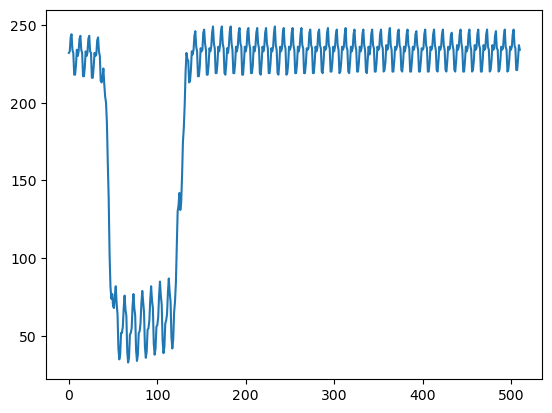

Finished 1 slice


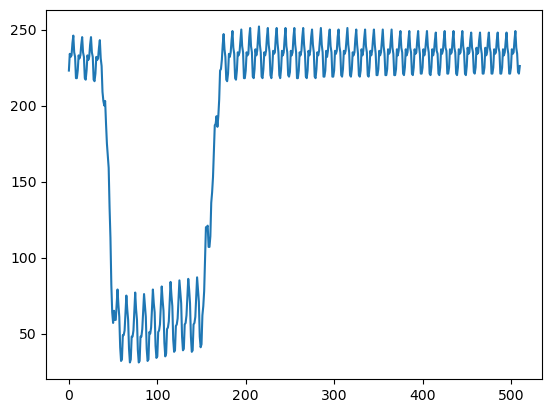

Finished 1 slice


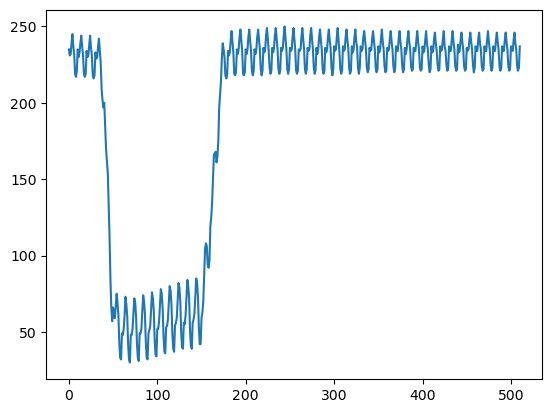

Finished 1 slice


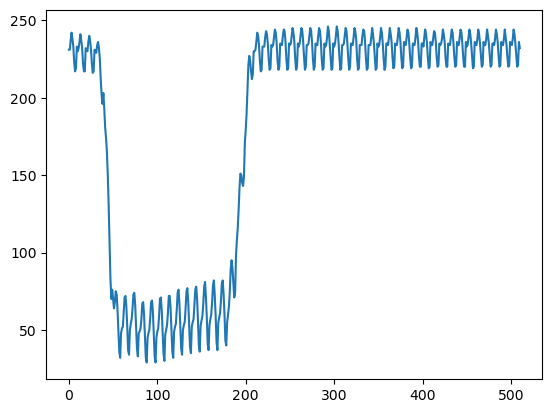

Finished 1 slice


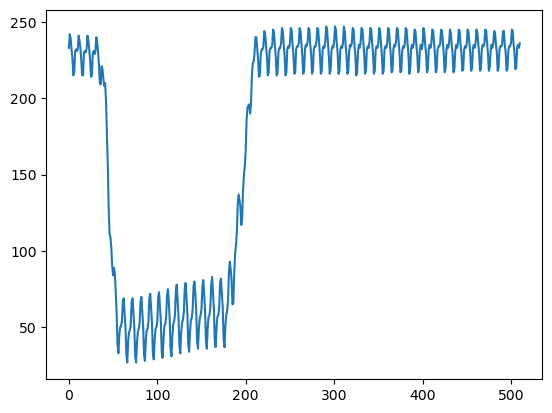

Finished 1 slice
nr of slices:5


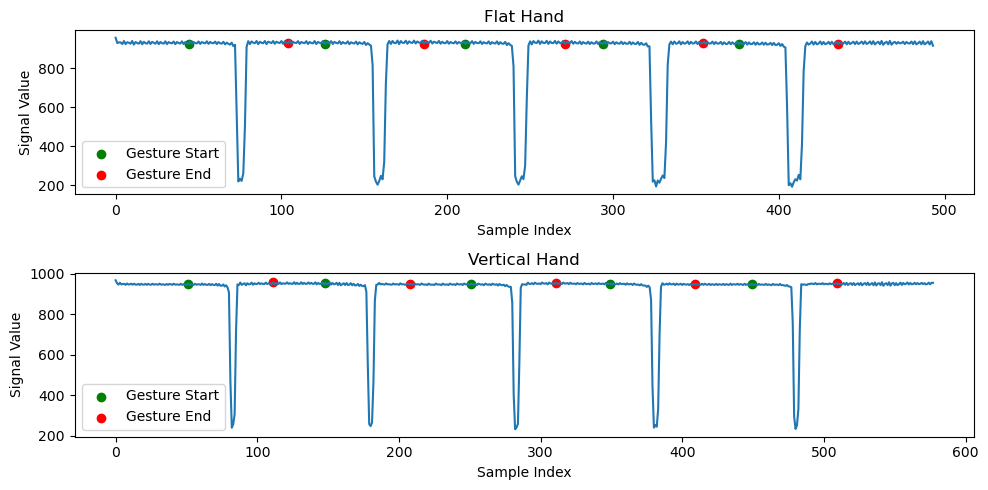

In [132]:
# During activity, keep reading Serial and add raw signal value into ringbuffer
last5s = RingBuffer(2500)
historyBuffer = RingBuffer(100)
sliceArray = []

busyReading = False
avgMean = 0
historyMean = 100000
samplingStep = 0
nrOfSlices = 0
for sigVal in solar_cell_1:
    if (not busyReading):
        # Add value to last 5s, to get average mean threshold
        last5s.append(sigVal)
        avgMean = np.mean(last5s.get())
        # Keep history record of signal, such that we know what happened, when we trigger the condition for a slice.
        historyBuffer.append(sigVal)
        historyMean = np.mean(historyBuffer.get())
    # Threshold determination part
    if historyMean < 0.6*avgMean and samplingStep < 412:
        busyReading = True
        if(len(sliceArray)<1):
            sliceArray = historyBuffer.get()
        else:
            sliceArray.append(sigVal)
        samplingStep+= 1
    elif (busyReading):
        plt.plot(sliceArray)
        plt.show()
        # Reset every intermediate value
        print("Finished 1 slice")
        samplingStep = 0
        busyReading = False
        historyMean = 1000000
        historyBuffer.clear()
        sliceArray = []
        nrOfSlices +=1
        

# dataTest = last5s.get()
# plt.plot(dataTest)
# plt.show()
print("nr of slices:" + str(nrOfSlices))

def detect_gesture_starts_ends(signal, window_size, std_threshold, mean_threshold):
    starts = []
    ends = []

    for i in range(len(signal) - window_size):
        window = signal[i:i+window_size]
        std_dev = np.std(window)
        mean = np.mean(window)
        last_sample = window[-1]

        if std_dev < std_threshold and abs(last_sample - mean) > mean_threshold:
            starts.append(i)
            ends.append(i + 2*window_size)

    return starts, ends

# get the start and end points of hand gesture
zscore_solar_cell_1 = stats.zscore(solar_cell_denoised_1)
zscore_solar_cell_2 = stats.zscore(solar_cell_denoised_2)
starts_flat, ends_flat = detect_gesture_starts_ends(zscore_solar_cell_1, 30, 0.5, 0.25) #the mean and std threshold should be changed?????????
starts_vertical, ends_vertical = detect_gesture_starts_ends(zscore_solar_cell_2, 30, 0.5, 0.25)
# Plot the first signal
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)  # Create a subplot with 2 rows and 1 column, select the first subplot
plt.plot(solar_cell_denoised_1)
plt.title('Flat Hand')

# Highlight the start and end points
plt.scatter(starts_flat, solar_cell_denoised_1[starts_flat], color='green', label='Gesture Start')
plt.scatter(ends_flat, solar_cell_denoised_1[ends_flat], color='red', label='Gesture End')

plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()

# Plot the second signal
plt.subplot(2, 1, 2)  # Select the second subplot
plt.plot(solar_cell_denoised_2)
plt.title('Vertical Hand')

# Highlight the start and end points
plt.scatter(starts_vertical, solar_cell_denoised_2[starts_vertical], color='green', label='Gesture Start')
plt.scatter(ends_vertical, solar_cell_denoised_2[ends_vertical], color='red', label='Gesture End')

plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()

plt.tight_layout()  # Adjust subplot layout for better spacing
plt.show()

In [80]:
def split_time_series(time_series, starts, ends):
    split_sequences = []

    for start, end in zip(starts, ends):
        split_sequences.append(time_series[start:end+1])
    
    return split_sequences

splited_solar_1 = split_time_series(solar_cell_1, starts_flat, ends_flat)
feature_coeffs_1 = []
feature_std_1 = []
feature_mean_1 = []
feature_min_1 = []
feature_max_1 = []
feature_difference_1 = []

splited_solar_2 = split_time_series(solar_cell_2, starts_vertical, ends_vertical)
feature_coeffs_2 = []
feature_std_2 = []
feature_mean_2 = []
feature_min_2 = []
feature_max_2 = []
feature_difference_2 = []

target_length = 512 #target window size of interpolate
for solar_slice_1 in splited_solar_1:
    #apply z score transformation on each slice
    zscore_cell1 = stats.zscore(solar_slice_1)
    
    ## Apply interpolate on every window (seems not correct)
    # Original signal with 61 sampling points
    original_signal = zscore_cell1  # Replace with your actual signal data
    # Create a time array for the original signal
    original_time = np.linspace(0, 1, len(original_signal))
    # Create a function for linear interpolation
    interpolator = interp1d(original_time, original_signal, kind='linear')
    # Create a time array for the upscaled signal
    upscaled_time = np.linspace(0, 1, 512)
    # Upscale the signal
    interpolated_solar_slice_1 = interpolator(upscaled_time)

    # calculate the detail coefficients of each slice
    slice_coeffs_1 = pywt.wavedec(interpolated_solar_slice_1, 'haar', level=5)
    feature_coeffs_1.append(slice_coeffs_1[1])
    std_dev = statistics.stdev(slice_coeffs_1[1])
    feature_std_1.append(std_dev)
    mean_val = np.mean(slice_coeffs_1[1])
    feature_mean_1.append(mean_val)
    min_val = np.min(slice_coeffs_1[1])
    feature_min_1.append(min_val)
    max_val = np.max(slice_coeffs_1[1])
    feature_max_1.append(max_val)
    feature_difference_1.append(max_val - min_val)

for solar_slice_2 in splited_solar_2:
    #apply z score transformation on each slice
    zscore_cell2 = stats.zscore(solar_slice_2)
    
    ## Apply interpolate on every window (seems not correct)
    # Original signal with 61 sampling points
    original_signal = zscore_cell2  # Replace with your actual signal data
    # Create a time array for the original signal
    original_time = np.linspace(0, 1, len(original_signal))
    # Create a function for linear interpolation
    interpolator = interp1d(original_time, original_signal, kind='linear')
    # Create a time array for the upscaled signal
    upscaled_time = np.linspace(0, 1, 512)
    # Upscale the signal
    interpolated_solar_slice_2 = interpolator(upscaled_time)

    # calculate the detail coefficients of each slice
    slice_coeffs_2 = pywt.wavedec(interpolated_solar_slice_2, 'haar', level=5)
    feature_coeffs_2.append(slice_coeffs_2[1])
    std_dev = statistics.stdev(slice_coeffs_2[1])
    feature_std_2.append(std_dev)
    mean_val = np.mean(slice_coeffs_2[1])
    feature_mean_2.append(mean_val)
    min_val = np.min(slice_coeffs_2[1])
    feature_min_2.append(min_val)
    max_val = np.max(slice_coeffs_2[1])
    feature_max_2.append(max_val)
    feature_difference_2.append(max_val - min_val)
    
print("Flat Hand")
# print(feature_coeffs_1)
print(feature_std_1)
print(feature_mean_1)
print("Vertical Hand")
# print(feature_coeffs_2)
print(feature_std_2)
print(feature_mean_2)

Flat Hand
[2.9382197749615413, 3.032099602317257, 3.0039389946499613, 3.032443586394955, 3.00405724438611]
[-0.01544956500428546, 0.028500894243431496, 0.03477642409685444, -0.047929411787383136, 0.07058167402324711]
Vertical Hand
[2.983300409623277, 2.917808287367333, 2.9680195409328674, 2.7877107917057447, 3.0472480342579]
[-0.05910938389816947, 0.010406789882566991, -0.1027302610463447, 0.16496288963353245, 0.16295108141852088]


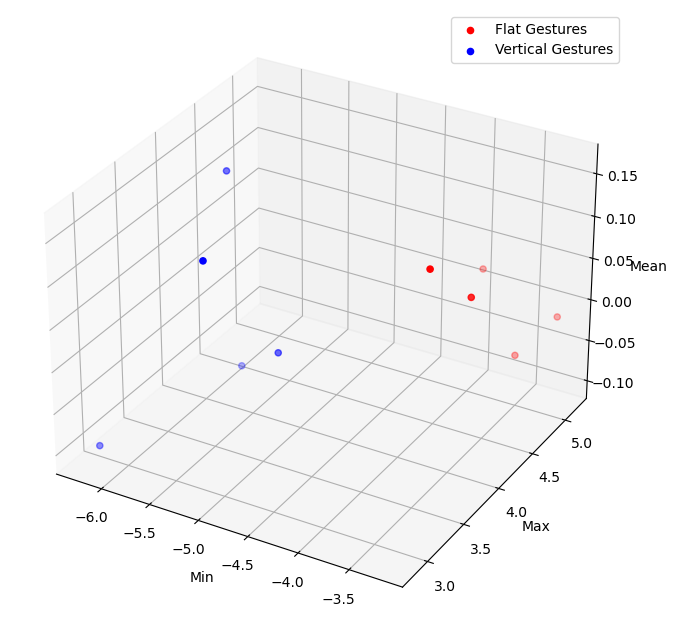

In [81]:
X_train_flat = np.column_stack((feature_min_1,feature_max_1, feature_mean_1))
X_train_vertical = np.column_stack((feature_min_2, feature_max_2, feature_mean_2))
X_train = np.concatenate((X_train_flat, X_train_vertical), axis=0)

Y_train = ["flat", "flat", "flat", "flat", "flat", "vertical", "vertical", "vertical", "vertical", "vertical"]
knn_model = KNeighborsClassifier(n_neighbors=3)  
knn_model.fit(X_train, Y_train)  # train the model

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

# Feature Extraction
min_1, std_1, mean_1 = X_train_flat[:, 0], X_train_flat[:, 1], X_train_flat[:, 2]
min_2, std_2, mean_2 = X_train_vertical[:, 0], X_train_vertical[:, 1], X_train_vertical[:, 2]

# Plot the figure
ax.scatter(min_1, std_1, mean_1, c='r', label='Flat Gestures')
ax.scatter(min_2, std_2, mean_2, c='b', label='Vertical Gestures')

# Add axises labels
ax.set_xlabel('Min')
ax.set_ylabel('Max')
ax.set_zlabel('Mean')

ax.legend()

plt.show()

In [ ]:
ser = serial.Serial('COM3', 115200) 

try:
    while True:
        data = ser.readline().decode('utf-8').strip()
        if data:
            predicted_gesture = knn_model.predict([data_vector])

            print(f'Predicted Gesture: {predicted_gesture}')

except KeyboardInterrupt:
    pass
finally:
   
    ser.close()